# Feature Engineering and Modeling

Taking all our yearly datatables, we will train our model on the given employment, membership, and wage data of a single year to predict the poverty level of a given state.    
We will then test this model on our other years.

### Import packages and read in data

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
final_2010 = pd.read_csv('../data/cleaned_data/model_data/2010/final_2010_bin.csv', index_col='State')
final_2011 = pd.read_csv('../data/cleaned_data/model_data/2011/final_2011_bin.csv',index_col='State')
final_2012 = pd.read_csv('../data/cleaned_data/model_data/2012/final_2012_bin.csv',index_col='State')
final_2013 = pd.read_csv('../data/cleaned_data/model_data/2013/final_2013_bin.csv',index_col='State')
final_2014 = pd.read_csv('../data/cleaned_data/model_data/2014/final_2014_bin.csv',index_col='State')
final_2015 = pd.read_csv('../data/cleaned_data/model_data/2015/final_2015_bin.csv',index_col='State')
final_2016 = pd.read_csv('../data/cleaned_data/model_data/2016/final_2016_bin.csv',index_col='State')
final_2017 = pd.read_csv('../data/cleaned_data/model_data/2017/final_2017_bin.csv',index_col='State')

#### Basic heatmap to visualize correlations

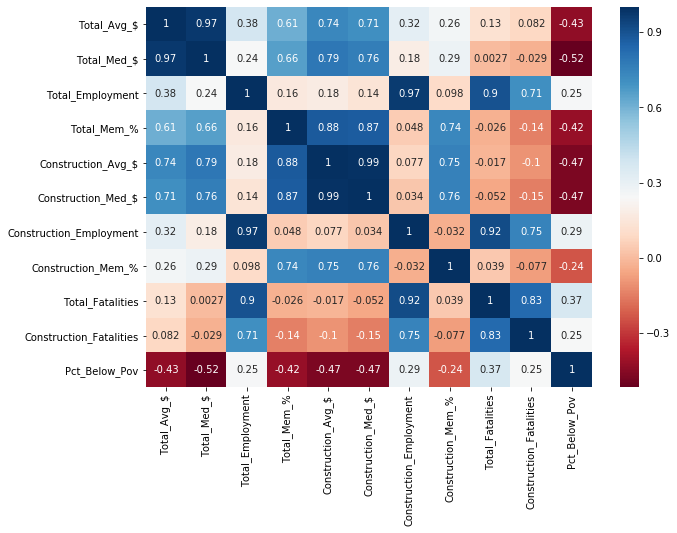

In [138]:
plt.figure(figsize=(10,7))
sns.heatmap(final_2010.corr(), cmap='RdBu', annot=True)

As we can see from the above heatmap, there is:
- A strong negative correlation between population union membership percentage (Total_Mem_%) and percentage of population below the poverty line (Pct_Below_Pov).
- A negative correlation between construction industry union membership percentage(Construction_Mem_%) and percentage of population below the poverty line.
- In addition to strong negative correlation expected between average wage across all industries & percentage of population below the poverty line, there exists a similarly strong negative correlation between average wage for workers in construction industry (Construction_Avg_$) and percentage of population below the poverty line. 
- A positive correlation between total union membership percentage (Total_Mem_%) and average annual wages across all industries.
- A positive correlation between both fatalities across all industries and those in construction (Total_Fatalities, Construction_Fatalities) and percentage of population below the poverty line.

## Feature Selection

In [4]:
X = final_2010.drop('Pct_Below_Pov', axis=1)
y = final_2010['Pct_Below_Pov']

Baseline:

In [5]:
y.value_counts(normalize=True)

0    0.56
1    0.44
Name: Pct_Below_Pov, dtype: float64

#### Train Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

### Modeling

Due to high correlations in our data, we will be using a Random Forest Classification model & a KNearestNeighbors model on 3 sets of data:
- Unaltered
- Data with interaction terms created
- Data with polynomial features created



### Random Forest Classifier

In [71]:
# instantiate pipeline
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier())])

In [90]:
# hyperparameter tuning
param_grid = {'rf__n_estimators':[3,4,5,6,8,9],
             'rf__min_samples_split': [4,5,6],
             'rf__max_features': [3,6,8],
             'rf__max_depth': [10,15,20,50,100,200]}

In [91]:
rf_grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=2)

#### Model 1, Unaltered Data

In [92]:
rf_grid = rf_grid.fit(X_train, y_train)

C:\Users\justanotheregg\Anaconda3\envs\dsi\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [94]:
print(f"RF model train score: {rf_grid.best_score_}")

RF model train score: 0.8918918918918919


In [88]:
rf_grid.best_params_

{'rf__max_depth': 200,
 'rf__max_features': 5,
 'rf__min_samples_split': 5,
 'rf__n_estimators': 4}

In [93]:
print(f"RF model test score: {rf_grid.score(X_test,y_test)}")

RF model test score: 0.8461538461538461


#### Model 2, Interaction Terms

In [95]:
pint = PolynomialFeatures(interaction_only=True,include_bias = False)
X_int = pint.fit_transform(X)

In [96]:
Xint_train, Xint_test, yint_train, yint_test = train_test_split(X_int,y, random_state=42)

In [97]:
rfint_grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=2)

In [98]:
rfint_grid = rfint_grid.fit(Xint_train, yint_train)

C:\Users\justanotheregg\Anaconda3\envs\dsi\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [99]:
print(f"RF interaction train score: {rfint_grid.best_score_}")

RF interaction train score: 0.8648648648648649


In [100]:
rfint_grid.best_params_

{'rf__max_depth': 10,
 'rf__max_features': 3,
 'rf__min_samples_split': 5,
 'rf__n_estimators': 9}

In [101]:
print(f"RF intereaction test score: {rfint_grid.score(Xint_test,yint_test)}")

RF intereaction test score: 0.7692307692307693


#### Model 3, Polynomial Features

In [102]:
poly = PolynomialFeatures(degree=2,include_bias = False)
X_poly = poly.fit_transform(X)

In [103]:
Xpoly_train, Xpoly_test, ypoly_train, ypoly_test = train_test_split(X_poly,y, random_state=42)

In [104]:
rfpoly_grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=2)

In [105]:
rfpoly_grid = rfpoly_grid.fit(Xpoly_train, ypoly_train)

C:\Users\justanotheregg\Anaconda3\envs\dsi\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [106]:
print(f"RF polynomial train score: {rfpoly_grid.best_score_}")

RF polynomial train score: 0.918918918918919


In [107]:
rfpoly_grid.best_params_

{'rf__max_depth': 10,
 'rf__max_features': 8,
 'rf__min_samples_split': 4,
 'rf__n_estimators': 9}

In [108]:
print(f"RF polynomail test score: {rfpoly_grid.score(Xpoly_test,ypoly_test)}")

RF polynomail test score: 0.6153846153846154


### KNearestNeighbors

In [109]:
pipe2 = Pipeline([
    ('ss', StandardScaler()),
('knn', KNeighborsClassifier())])

In [110]:
param_grid2 = {'knn__n_neighbors':[3,4,5,6,10],
              'knn__p':[1,2]}

In [111]:
knn_grid = GridSearchCV(pipe2, param_grid2, cv=5, n_jobs=2)

#### Model 1, Unaltered Data

In [112]:
knn_grid = knn_grid.fit(X_train, y_train)

C:\Users\justanotheregg\Anaconda3\envs\dsi\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [113]:
print(f"KNN train score:{knn_grid.best_score_}")

KNN train score:0.8378378378378378


In [114]:
knn_grid.best_params_

{'knn__n_neighbors': 10, 'knn__p': 1}

In [115]:
print(f"KNN test score: {knn_grid.score(X_test,y_test)}")

KNN test score: 0.6923076923076923


#### Model 2, Interaction Terms

In [116]:
knn_int = knn_grid.fit(Xint_train, yint_train)

C:\Users\justanotheregg\Anaconda3\envs\dsi\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [117]:
print(f"KNN interaction train score: {knn_int.best_score_}")

KNN interaction train score: 0.8108108108108109


In [118]:
knn_int.best_params_

{'knn__n_neighbors': 5, 'knn__p': 2}

In [119]:
print(f"KNN interaction test score: {knn_int.score(Xint_test,yint_test)}")

KNN interaction test score: 0.6153846153846154


#### Model 3, Polynomial Features

In [120]:
knn_poly = knn_grid.fit(Xpoly_train, ypoly_train)

C:\Users\justanotheregg\Anaconda3\envs\dsi\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [121]:
print(f"KNN polynomial train score: {knn_poly.best_score_}")

KNN polynomial train score: 0.8378378378378378


In [122]:
knn_poly.best_params_

{'knn__n_neighbors': 5, 'knn__p': 2}

In [123]:
print(f"KNN polynomial test score: {knn_poly.score(Xpoly_test,ypoly_test)}")

KNN polynomial test score: 0.6153846153846154


#### The highest performing model was the Random Forest Classifier with unaltered features, with an accuracy of ~90% on the training data, and ~85% on testing data.

Because poverty rate of a given state is such a multilayered statistic, it is impossible to expect a model with fewer than 100s of features, made up of precisely gathered data, to predict it with total accuracy. Because our model focuses on particular datapoints (union membership and wages for population within the construction industry) to show that a prediction is possible based on these factors realtion to poverty rate, this accuracy rate is very acceptable.    
That accurate predictions of poverty threshold of states can be made using our chosen features, shows a clear relationship.

#### Testing our model on 2011-2017 data

In [124]:
X_2011 = final_2011.drop('Pct_Below_Pov', axis=1)
y_2011 = final_2011['Pct_Below_Pov']

In [125]:
rf_grid.score(X_2011,y_2011)

0.8775510204081632

In [126]:
X_2012 = final_2012.drop('Pct_Below_Pov', axis=1)
y_2012 = final_2012['Pct_Below_Pov']

In [127]:
rf_grid.score(X_2012,y_2012)

0.7755102040816326

In [128]:
X_2013 = final_2013.drop('Pct_Below_Pov', axis=1)
y_2013 = final_2013['Pct_Below_Pov']

In [129]:
rf_grid.score(X_2013,y_2013)

0.8163265306122449

In [130]:
X_2014 = final_2014.drop('Pct_Below_Pov', axis=1)
y_2014 = final_2014['Pct_Below_Pov']

In [131]:
rf_grid.score(X_2014,y_2014)

0.8163265306122449

In [132]:
X_2015 = final_2015.drop('Pct_Below_Pov', axis=1)
y_2015 = final_2015['Pct_Below_Pov']

In [133]:
rf_grid.score(X_2015,y_2015)

0.7346938775510204

In [134]:
X_2016 = final_2016.drop('Pct_Below_Pov', axis=1)
y_2016 = final_2016['Pct_Below_Pov']

In [135]:
rf_grid.score(X_2016,y_2016)

0.7142857142857143

In [136]:
X_2017 = final_2017.drop('Pct_Below_Pov', axis=1)
y_2017 = final_2017['Pct_Below_Pov']

In [137]:
rf_grid.score(X_2017,y_2017)

0.7142857142857143